# Description of the mini-project

## Dataset

In this mini-project we will work with a dataset used in the *EE-490 Lab in Data Science* course. It is composed of CO2 measurements taken from a pool of 46 cheap but inaccurate sensors deployed in the city of Zurich. In addition, we also have access to temperature and humidity measurements, the altitude of the sensor as well as the average daily wind pattern for the city.

## Prior Knowledge

Measurements highly depends on the temperature, the humidity, the wind, the altitude and the level of traffic around the site. For example, a sensor that is located in a mountain with high altitude and exposed to strong winds is expected to have a much lower and uniform level of CO2 compared to another sensor that is located near the center of the city and close to a busy industrial zone exposed to high traffic activity. We also know that there is a strong dependence of the CO2 measurements on the temperature and the humidity.

## Assumption

Sensors in similar conditions are expected to have similar measurements.

## Issue

It might be the case that one sensor suddenly begins to take wrong measurements. The detection of faulty sensors is done by an external domain expert. Then, our job consists in curate the CO2 measurements for that particular sensor through our regression model.

## Goal

Fit a linear regression model to the CO2 measurements based on the aforementioned features. Do a performance evaluation between several models by comparing the fitting time and the goodness of fit.

## Proposed solution and structure

Our proposed solution can be decomposed in the following parts:

* Preprocessing: features come in different files, we need to aggregate them and make sure the data comes exempt from missing values or any defect. K-means is used to optimally group sensor that are in similar conditions, such as altitude and wind exposure.
* Faulty sensor modeling: in order to test our model's ability to fit the lost measurements, we need to model the faulty sensors. In this way we will be able to compare our prediction against the true measurements.
* Performance evaluation: compare the different models and select the most appropriate one.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn import decomposition
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import array
from tqdm import tqdm_notebook as tqdm
from math import pi
import random
random.seed(2019)

# main variables
K_cluster_altitude = 10
K_cluster_wind = 8

## Define type of models


### Plotting functions 

In [2]:
def kiviat_diagram(df):
    
    # number of variable
    metrics =list(df)[1:]
    N_metrics = len(metrics)
    
    # (we divide the plot / number of variable) to get an equal radial subdivision
    angles = [n / float(N_metrics)*2*pi for n in range(N_metrics)]
    angles += angles[:1]
    
    ticks = np.arange(0,np.max(df.values[:,1:] +  1),10)
    #plot
    for i in range(len(df)):
        values=df.loc[i].drop('group').values.flatten().tolist()
        #in order to have a triangular structure
        values += values[:1]

        # Initialise the spider plot
        ax = plt.subplot(111, polar=True)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], metrics, color='grey', size=8)

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(ticks, [], color="grey", size=7)
        plt.ylim(0,ticks[-1])

        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')

        # Fill area
        ax.fill(angles, values, 'w', alpha=0.1)     

/Users/Joel/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


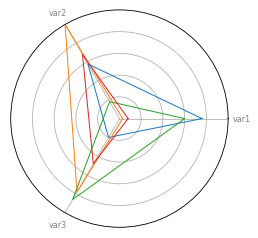

In [3]:
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 50, 9, 34],
'var3': [10, 39, 43, 24],
})
kiviat_diagram(df)

## Preprocessing

### Merging CO2 measurements, temperature and humidity in a single dataframe.

In [4]:
# Load the data
CO2_measurement = pd.read_csv('data/CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('data/zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('data/temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('data/sensors_metadata.csv', sep='\t') 

# Some values are missing, that is why we will interpolate them by taking the average over an interval of 30min.
# We will also aggregate all the information of CO2 measurements, temperature and humidity into one single 
# dataframe for more practicality.

# interpolate CO2_measurement
CO2_measurement = CO2_measurement.interpolate().set_index('timestamp')
CO2_measurement.index = pd.to_datetime(CO2_measurement.index)
grouper = CO2_measurement.groupby([pd.Grouper(freq='30Min'), 'LocationName', 'SensorUnit_ID'])
grouper = grouper.mean()


# interpolate temperature and humidity
zurich_temp_humidity = zurich_temp_humidity.interpolate().set_index('Timestamp')
zurich_temp_humidity.index.names = ['timestamp']
zurich_temp_humidity.index = pd.to_datetime(zurich_temp_humidity.index)
zurich_temp_humidity = zurich_temp_humidity.resample('30Min').mean()

# merge the two dataframes
grouper = grouper.reset_index()
mth = pd.DataFrame()
for e in tqdm(zurich_temp_humidity.columns[::2]):
    id_ = int(e.split('.')[0])
    df = zurich_temp_humidity[['{}.temperature'.format(id_), '{}.humidity'.format(id_)]].rename(
        columns={
            '{}.temperature'.format(id_): 'temperature',
            '{}.humidity'.format(id_):'humidity'
        }
    )
    df['SensorUnit_ID'] = id_
    mth = mth.append(grouper.merge(df.reset_index(), on=['timestamp', 'SensorUnit_ID'])) 
mth = mth.set_index('timestamp')

In [5]:
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


### Applying K-means for the altitude and wind exposure.

For the altitude: K-means will be computed based on two features of the sensor. Its altitude and its median of the CO2 measurements for the entire month.

In [6]:
# take the median of the CO2_measurements
CO2_measurements = mth[['LocationName', 'CO2']].groupby([pd.Grouper(freq='1M'), 'LocationName'])\
                    .median().reset_index().drop('timestamp', 1).set_index('LocationName')

# select only altitude from the metadata
altitude = sensors_metadata[['LocationName', 'altitude']].set_index('LocationName')

# join both features in a single dataframe
ma = CO2_measurements.join(altitude)
ma.rename(columns={'CO2': 'median CO2'}, inplace=True)
ma.head()

,median CO2,altitude
LocationName,,
AJGR,334.785793,627.8
BSCR,475.316233,462.3
BUDF,422.793126,490.2
KBRL,410.100150,510.5
KTGM,444.395518,530.3


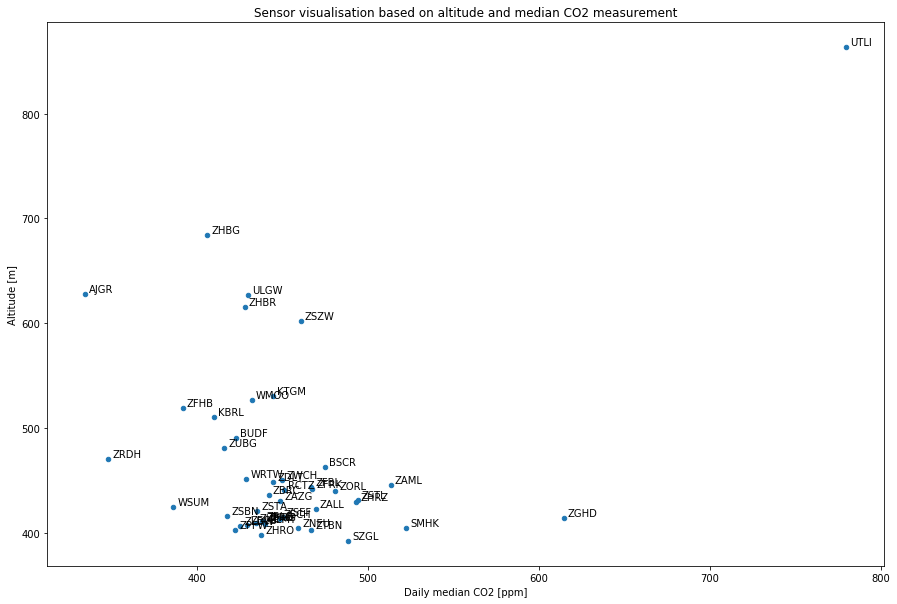

In [7]:
ax = ma.plot(x='median CO2', y='altitude', kind='scatter', figsize=(15, 10))

for k, v in ma.iterrows():
    ax.annotate(k, v, xytext=(4,2), textcoords='offset points', fontsize=10)

plt.title('Sensor visualisation based on altitude and median CO2 measurement')
plt.xlabel('Daily median CO2 [ppm]')
plt.ylabel('Altitude [m]')
plt.show()

#### Determine the correct value of k

In [8]:
def plot_elbow_method(ma, search_space=range(2,11)):
   
    X = ma.values
    kmeans = [KMeans(i) for i in search_space]
    scores = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.plot(search_space, scores)
    plt.title('Elbow method for optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.yticks([])
    plt.grid()
    plt.show()

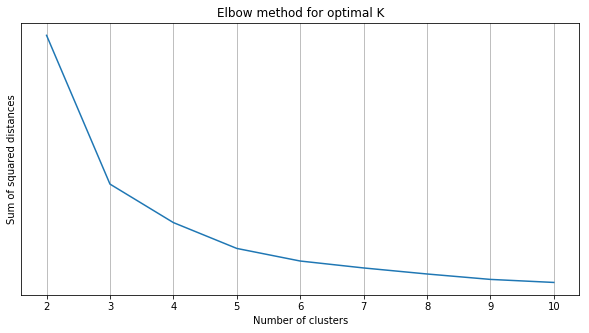

In [9]:
plot_elbow_method(ma[['median CO2', 'altitude']])

In [10]:
"""X = ma.values
range_k = range(2,11)
for k in range_k:
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"""

"X = ma.values\nrange_k = range(2,11)\nfor k in range_k:\n    cluster = KMeans(n_clusters=k)\n    cluster_labels = cluster.fit_predict(X)\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"

In [11]:
ma['altitude_cluster'] = KMeans(K_cluster_altitude).fit(ma[['median CO2', 'altitude']]).labels_
ma.head()

,median CO2,altitude,altitude_cluster
LocationName,,,
AJGR,334.785793,627.8,7
BSCR,475.316233,462.3,0
BUDF,422.793126,490.2,3
KBRL,410.100150,510.5,3
KTGM,444.395518,530.3,3


In [12]:
# merge the in to current dataframe
mth = mth.reset_index().merge(ma.reset_index(), on='LocationName').set_index('timestamp')
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster
timestamp,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,4
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097,614.578185,413.5,4
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761,614.578185,413.5,4
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734,614.578185,413.5,4
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937,614.578185,413.5,4


For the wind exposure: we will perform a Principle Component Analysis (PCA) to reduce the dimension to 2 (instead of 48) for a single and perform a daily clustering based on these PCA coefficients.

In [13]:
# load the dataframe
ZU_aw = zurich_average_wind.copy()
ZU_aw.set_index('timestamp', inplace=True)
ZU_aw.index = pd.to_datetime(ZU_aw.index)
ZU_aw.head()

# reorganize structure to perform dimension reduction
daily_sample = pd.DataFrame(columns=list(range(48)))
for index, row in ZU_aw.groupby(ZU_aw.index.day):
    day = row.index[0].date()
    daily_sample.loc[day] = row.values.T[0]

# apply PCA decomposition
pca = decomposition.PCA(n_components=2)
pca_components = pd.DataFrame(columns=['component_1', 'component_2'], index=daily_sample.index)
components_values = pca.fit_transform(daily_sample.values)
pca_components.loc[:] = components_values
pca_components.index.names = ['timestamp']
pca_components.head()

,component_1,component_2
timestamp,,
2017-10-01,-4.106523,-1.663550
2017-10-02,-0.869377,4.207631
2017-10-03,8.023951,-8.309913
2017-10-04,-3.281485,-0.074907
2017-10-05,8.288445,11.560985


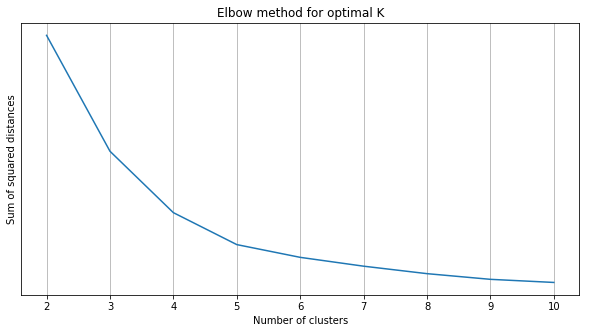

In [14]:
plot_elbow_method(pca_components[['component_1', 'component_2']])

In [15]:
pca_components['wind_cluster'] = KMeans(K_cluster_wind).fit(pca_components[['component_1', 'component_2']]).labels_
pca_components.head()

,component_1,component_2,wind_cluster
timestamp,,,
2017-10-01,-4.106523,-1.663550,1
2017-10-02,-0.869377,4.207631,7
2017-10-03,8.023951,-8.309913,0
2017-10-04,-3.281485,-0.074907,7
2017-10-05,8.288445,11.560985,6


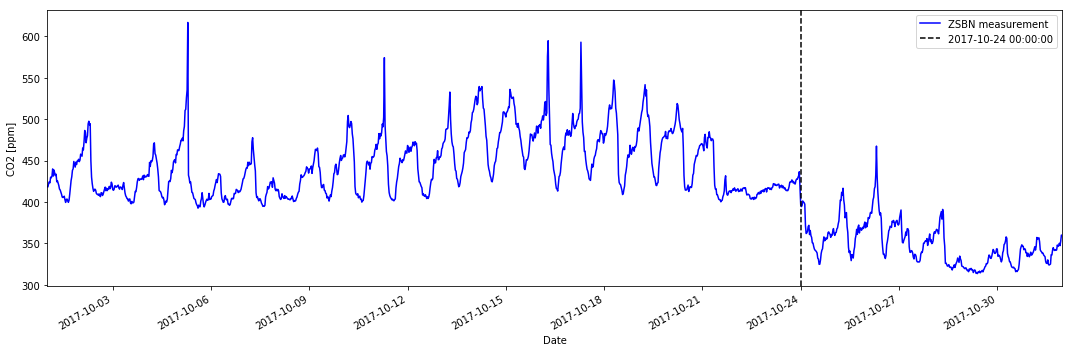

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
mask = mth['LocationName'] == 'ZSBN'
mth[mask]['CO2'].plot(ax=ax, color='b', label='ZSBN measurement')
plt.axvline(x=pd.to_datetime('2017-10-24 00:00:00'), color='k', linestyle='--', label='2017-10-24 00:00:00')
plt.legend()
plt.ylabel('CO2 [ppm]')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('figures/zsbn_sensor.png', dpi=300)

## Faulty sensor modeling

Despite a request to the teaching staff for information about how to properly model a faulty sensor, no useful details have been provided to us as they were mainly guided by the domain experts. Thus, the only behaviour from which we can draw inspiration from is that of the sensor `ZSBN`. In addition, we know that the change occurs after October 24th. The figure below shows the results obtained from the past homework.

![caption](figures/zsbn_sensor.png)

Although this would require further investigation, we choose a simplistic approach: we will model a faulty sensor as one that undergoes a drift (up or down) and a rescale in amplitude. 

### Create faulty sensors

We will generate faulty sensor from three of them: `AJGR`, `BSCR`, `BUDF`. We will also set the date of failure from the 24th of October. The main reason is that we will only lost about 25% of the data and the remaining 75% of the data will be used for training. We think that the percentage of training data plays a big role in the accuracy of the prediction.

In [17]:
def generate_faulty_sensors(df, sensors, failure_date=24):
    for sensor in sensors:
        co2_measurments = df[df['LocationName'] == sensor]['CO2'].copy()
        df.loc[df['LocationName'] == sensor,'groundtruth'] = co2_measurments.copy()
        condition = co2_measurments.index.day >= failure_date
        std = np.std(co2_measurments.values)
        drift = random.randint(30, 60)
        sign = random.sample([-1, 1], 1)[0]
        pourcentage = random.uniform(0.2, 0.3)
        co2_measurments.loc[condition] = (co2_measurments.loc[condition] - sign*drift)/std/pourcentage
        df.loc[df['LocationName'] == sensor, 'CO2'] = co2_measurments
        
def plot_faulty_sensor(df, sensor):
    fig, ax = plt.subplots(figsize=(15,5))
    df[df['LocationName'] == sensor][['CO2', 'groundtruth']].plot(ax=ax, color=['g', 'b'])
    plt.title('Example of inaccurate measurement generation for {} sensor'.format(sensor))
    plt.xlabel('Date')
    plt.ylabel('CO2 [ppm]')
    plt.legend(['artifical measurement', 'true measurement'])
    plt.show()

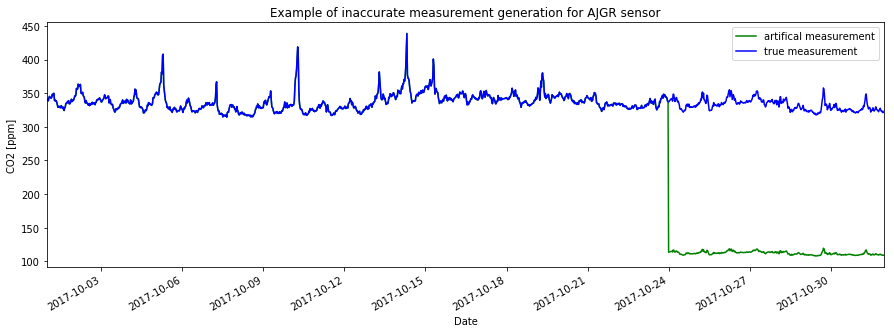

In [18]:
df_mth = mth.copy()
faulty_sensors = ['AJGR', 'BSCR', 'ZSTA', 'ZUE']
generate_faulty_sensors(df_mth, faulty_sensors)
plot_faulty_sensor(df_mth, 'AJGR')

## Information criterion


In [19]:
aic = {}

## Performance Evaluation

### 1) Naive Approach with different methods implemented. These methods can be tweaked to get the best results
Rely solely on the faulty sensor.

In [20]:
df_mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth
timestamp,,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,4,NaN
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097,614.578185,413.5,4,NaN
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761,614.578185,413.5,4,NaN
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734,614.578185,413.5,4,NaN
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937,614.578185,413.5,4,NaN


In [21]:
def compute_regs(df, mask, X_train, y_train, X_test, approach):
    
    models = {'LinearRegression_prediction':LinearRegression(), 'Lasso_prediction':Lasso(),
              'Ridge_prediction':Ridge(), 'ElasticNet_prediction':ElasticNet()}
    
    aic_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        if(approach != 'wt') :
            y_pred = model.predict(X_test)
            y_pred_name = '{}_'.format(approach) + name
            df.loc[mask, y_pred_name] = y_pred
            
            #save number of parameters per model to compute aic later on    
            aic_models[name] =  model.coef_.reshape(1,-1).shape[1]
            
    aic[approach] = aic_models
        
    return models

def bootstrap(y, residuals):
    from random import sample
    residuals = list(residuals)
    ys=[]
    for i in range(1000):
        residual = sample(residuals, 1)[0]
        ys.append(y+residual)
    ys.sort()
    return ys[25], ys[975]

def compute_ci(df, train_mask, res_mask, approach, reg):
    
    train_residuals = df[train_mask]['groundtruth'] - df[train_mask]['{}_{}_prediction'.format(approach, reg)]
    y_pred = df[res_mask]['{}_{}_prediction'.format(approach, reg)]
    
    y_hat = y_pred
    y_hat_bounds = []
    for i in range(y_hat.shape[0]):
        y_hat_bounds.append(bootstrap(y_hat[i], train_residuals))
    
    y_hat_lower_bound, y_hat_upper_bound = zip(*y_hat_bounds)
    df.loc[res_mask, '{}_{}_lower_bound'.format(approach, reg)] = y_hat_lower_bound
    df.loc[res_mask, '{}_{}_upper_bound'.format(approach, reg)] = y_hat_upper_bound

In [22]:
def naive_regression(df, faulty_sensors, failure_date=24):
    
    features = ['temperature','humidity']
    target = ['CO2']
    sensor_dict_result = {}
    for sensor in faulty_sensors:
        
        write_mask = df['LocationName'] == sensor
        train_mask = write_mask & (df.index.day < failure_date)
        test_mask = write_mask
        res_mask = test_mask & (df.index.day >= failure_date)
        
        X_train = df[train_mask][features].values
        y_train = df[train_mask][target].values
        X_test = df[test_mask][features].values
        
        compute_regs(df, write_mask, X_train, y_train, X_test, 'naive', )
        compute_ci(df, train_mask, res_mask, 'naive', 'LinearRegression')

In [23]:
naive_regression(df_mth, faulty_sensors)

In [24]:
df_mth[(df_mth['LocationName'] == 'AJGR') & (df_mth.index.day >=24)].head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth,naive_ElasticNet_prediction,naive_Lasso_prediction,naive_Ridge_prediction,naive_LinearRegression_prediction,naive_LinearRegression_lower_bound,naive_LinearRegression_upper_bound
timestamp,,,,,,,,,,,,,,,
2017-10-24 00:00:00,AJGR,1122,113.574027,6.753333,95.641973,334.785793,627.8,7,336.915833,341.261943,341.254125,341.156826,341.156703,323.762492,369.357423
2017-10-24 00:30:00,AJGR,1122,113.893428,6.850000,94.735664,334.785793,627.8,7,338.020819,340.866543,340.861304,340.730043,340.729889,324.124535,368.273261
2017-10-24 01:00:00,AJGR,1122,114.144441,6.900000,94.317319,334.785793,627.8,7,338.889211,340.689329,340.685222,340.539332,340.539165,322.860177,368.082537
2017-10-24 01:30:00,AJGR,1122,114.620098,6.843333,94.334167,334.785793,627.8,7,340.534774,340.642624,340.639064,340.483126,340.482949,322.810265,364.306457
2017-10-24 02:00:00,AJGR,1122,114.702936,6.700000,94.568136,334.785793,627.8,7,340.821359,340.628078,340.625136,340.454923,340.454733,323.375389,369.971505


In [25]:
def plot_prediction(df, sensor, prediction, reg):
    fig, ax = plt.subplots(figsize=(15,5))
    df[df['LocationName'] == sensor][['CO2', 'groundtruth', '{}_{}_prediction'.format(prediction, reg)]].plot(ax=ax, color=['g', 'b', 'r'])
    plt.title('Prediction using {} {} approach for {} sensor'.format(prediction, reg, sensor))
    plt.xlabel('Date')
    plt.ylabel('CO2 [ppm]')
    plt.legend(['artifical measurement', 'true measurement', '{} {} prediction'.format(prediction, reg)])
    plt.show()
    
def plot_zoomed_prediction(df, sensor, prediction, reg, ci=False, failure_date=24):
    fig, ax = plt.subplots(figsize=(10,5))
    mask = (df['LocationName'] == sensor) & (df.index.day >= failure_date)
    df[mask][['groundtruth', '{}_{}_prediction'.format(prediction, reg)]].plot(ax=ax, color=['b', 'r'])
    if ci:
        x = df[mask].index
        lower_bounds = df[mask]['{}_{}_lower_bound'.format(prediction, reg)]
        upper_bounds = df[mask]['{}_{}_upper_bound'.format(prediction, reg)]
        p2 = ax.fill_between(x, lower_bounds, upper_bounds, color='r', alpha=0.2, label='95% level')
    plt.title('Prediction using {} {} approach for {} sensor (zoomed)'.format(prediction, reg, sensor))
    plt.xlabel('Date')
    plt.ylabel('CO2 [ppm]')
    plt.legend(['true measurement', '{} prediction'.format(prediction), '95% ci'])
    plt.show()

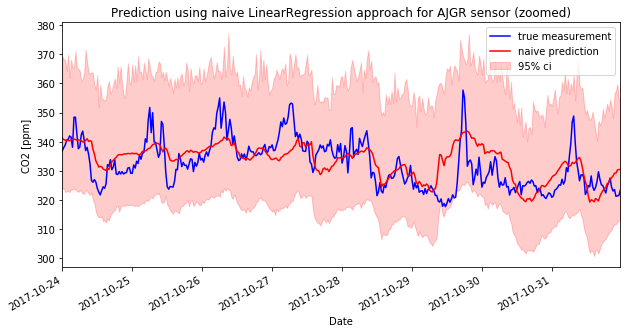

In [26]:
plot_zoomed_prediction(df_mth, 'AJGR', 'naive', 'LinearRegression', ci=True)

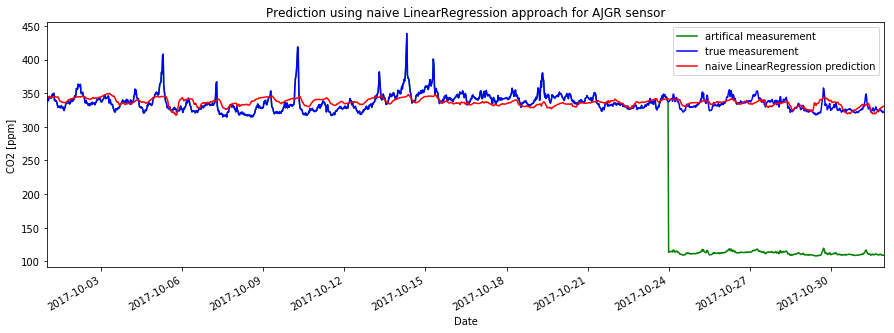

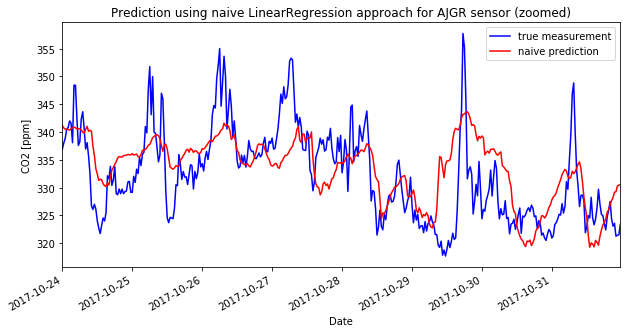

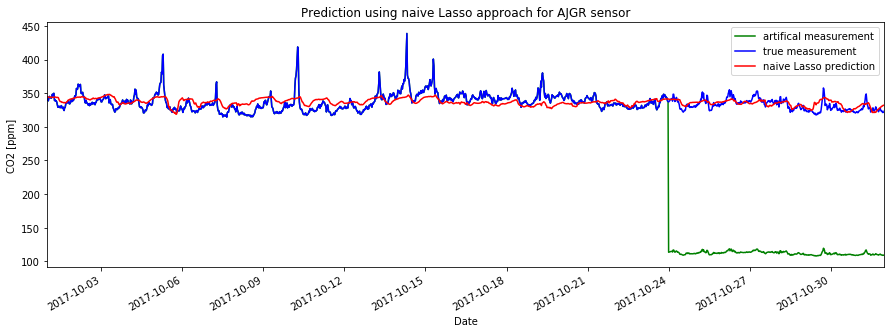

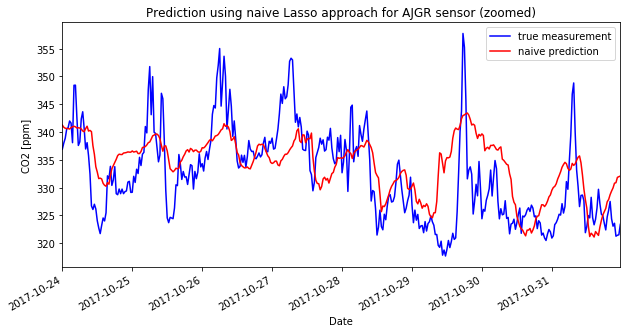

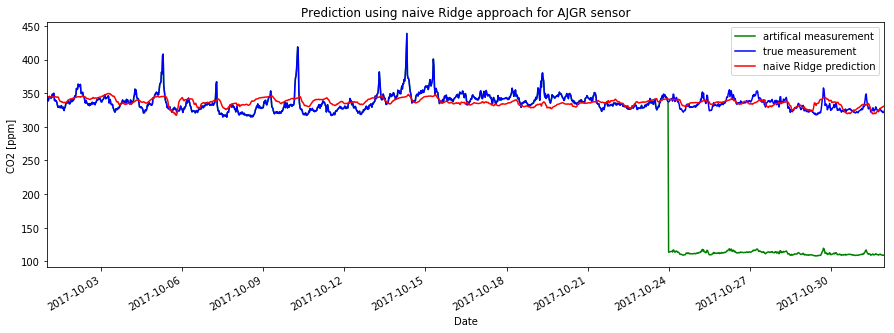

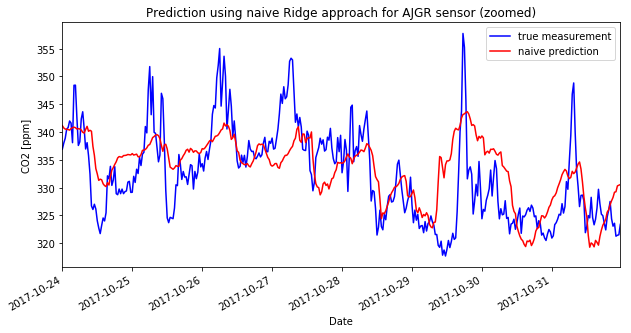

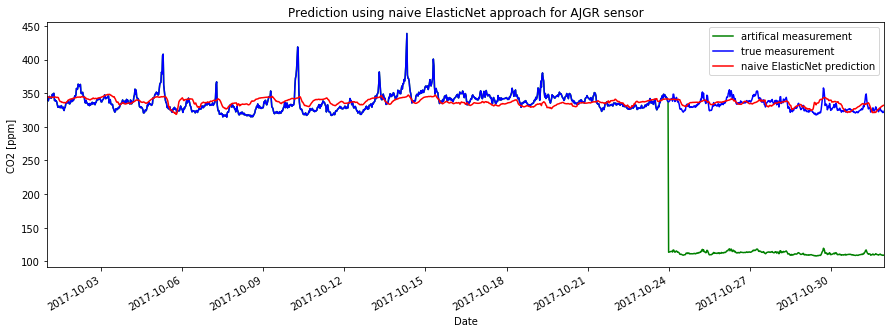

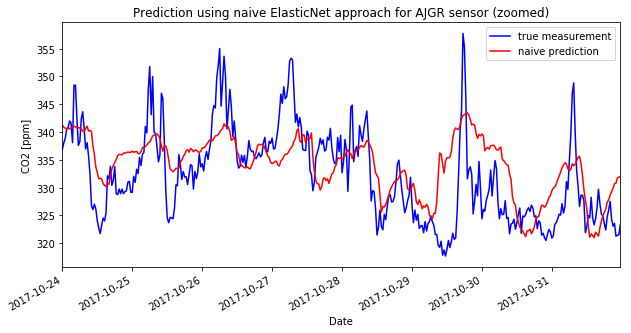

In [27]:
regs = ['LinearRegression','Lasso', 'Ridge', 'ElasticNet']
sensor = 'AJGR'
approach = 'naive'
for reg in regs:
    plot_prediction(df_mth, sensor, approach, reg)
    plot_zoomed_prediction(df_mth, sensor, approach, reg)

### 2) Add zone and altitude information (za) with other techniques (ridge, elastic net, lasso)
We will now make use of the zone of the sensor as well as the clustering on the altitude to train the linear regression.

### Todo Parameters to tweak

In [28]:
def za_regression(df, df_altitude, df_metadata, faulty_sensors, failure_date=24):
    
    features = ['temperature', 'humidity']
    for sensor in faulty_sensors:
        
        # aggregate sensors from same zone and cluster altitude
        zone = df_metadata[df_metadata['LocationName'] == sensor]['zone']
        sensors_same_zone = df_metadata[df_metadata['zone'] == zone.values[0]]['LocationName']
        altitude_cluster_id = df_altitude.loc[sensor, 'altitude_cluster']
        sensors_same_altitude_cluster = df_altitude[df_altitude['altitude_cluster'] == altitude_cluster_id].index
        sensors = set(sensors_same_zone).intersection(set(sensors_same_altitude_cluster))
        #print(sensor, sensors)
        
        # prepare masks for train and test
        healthy_mask = df['LocationName'].isin(sensors) & ~df['LocationName'].isin(faulty_sensors)
        nonhealthy_mask = df['LocationName'].isin(sensors) & df['LocationName'].isin(faulty_sensors) & (df.index.day < failure_date)
        
        train_mask = healthy_mask | nonhealthy_mask
        test_mask = (df['LocationName'] == sensor)
        write_mask = test_mask
        
        # create train data
        X_train = df.loc[train_mask][features].values
        y_train = df.loc[train_mask][['CO2']].values
        
        # create test data
        X_test = df.loc[test_mask][features].values
        y_test = df.loc[test_mask][['CO2']].values
        
        compute_regs(df, write_mask, X_train, y_train, X_test, 'za')
        
        """predictions = compute_techniques(X_train, y_train, X_test, y_test, sensor, models)
        
        # fit the model
        reg = linear_model.LinearRegression()
        reg.fit(X_train, y_train)
        
        # predict and pad prediction
        y_pred = reg.predict(X_test)
        num_to_pad = df[df['LocationName'] == sensor].shape[0] - y_pred.shape[0]
        
        y_pred_ridge = predictions['ridge']
        y_pred_elastic_Net = predictions['elastic_Net']
        y_pred_lasso = predictions['lasso']
        
        y_pred = np.pad(y_pred, ((num_to_pad, 0), (0,0)), 'constant', constant_values=(np.nan))
        y_pred_ridge = np.pad(y_pred_ridge, ((num_to_pad, 0), (0,0)), 'constant', constant_values=(np.nan))
        y_pred_elastic_Net = np.pad(y_pred_elastic_Net, ((num_to_pad, 0), (0,0)), 'constant', constant_values=(np.nan))
        y_pred_lasso = np.pad(y_pred_lasso, ((num_to_pad, 0), (0,0)), 'constant', constant_values=(np.nan))
        
            
        #store result
        df.loc[df['LocationName'] == sensor, 'za_prediction'] = y_pred
        df.loc[df['LocationName'] == sensor, 'za_predictionRidge'] = y_pred_ridge
        df.loc[df['LocationName'] == sensor, 'za_predictionElastic_Net'] = y_pred_elastic_Net
        df.loc[df['LocationName'] == sensor, 'za_predictionLasso'] = y_pred_lasso
        
        
        
        #write_mask = df['LocationName'] == sensor
        #df.loc[write_mask, 'za_prediction'] = y_pred"""

In [29]:
za_regression(df_mth, ma, sensors_metadata, faulty_sensors)

In [30]:
"""sensor = 'AJGR'
technique = 'za'

for method in methods :
    plot_prediction(df_mth, sensor, technique, method)
    plot_zoomed_prediction(df_mth, sensor, technique, method)"""

"sensor = 'AJGR'\ntechnique = 'za'\n\nfor method in methods :\n    plot_prediction(df_mth, sensor, technique, method)\n    plot_zoomed_prediction(df_mth, sensor, technique, method)"

In [31]:
def AIC(y, y_pred, k):
    
    resid  = np.sum((y-y_pred)**2) 
    return -2*np.log(resid) + 2*k

def BIC(y, y_pred, k):
    
    n = len(y_pred)
    resid  = np.sum((y-y_pred)**2) 
    
    return n*np.log(resid/n) + k*np.log(n)


In [32]:
def print_MSE(df, sensors, approaches, regs, failure_date=24):
    for sensor in sensors:
        mask = (df['LocationName'] == sensor) & (df.index.day >= failure_date)
        print()
        print('{} sensor'.format(sensor))
        print(11*'-')
        for approach in approaches:
            print('*****')
            for reg in regs:
                print('MSE for {} {} prediction: {:.2f}'.format(
                    approach, reg,
                    mean_squared_error(df[mask]['groundtruth'], df[mask]['{}_{}_prediction'.format(approach, reg)]))
                )
                
                """k = aic[approach][reg+"_prediction"]
                print('AIC for {} {} prediction: {:.3f}'.format(
                    approach, reg,
                    AIC(df[mask]['groundtruth'], df[mask]['{}_{}_prediction'.format(approach, reg)],k)
                ))
                
                print('BIC for {} {} prediction: {:.3f}'.format(
                    approach, reg,
                    BIC(df[mask]['groundtruth'], df[mask]['{}_{}_prediction'.format(approach, reg)],k)
                ))
                
                print("-")"""
                

### remove

In [33]:
regs = ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet']
approaches = ['naive', 'za', 'brute_force','wt']

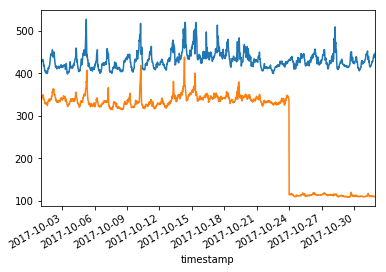

In [34]:
# Il faudra essayer d'expliquer la grosse différence pour AJGR entre naive et za, peut-être avec le wind pattern
# + time of day features cela va disparaître ou s'atténuer. Mais c'est bien car on à trois cas différents.
df_mth[df_mth['LocationName']=='ZHBR']['CO2'].plot()
df_mth[df_mth['LocationName']=='AJGR']['CO2'].plot()

### 3) Add the wind pattern and time feature (wt)
Make use of the different wind patterns to train a new regression model for each of the clusters. In addition, we will add another feature that corresponds to the time of the day (range between 0 and 47) and which represents the intervals of 30min.

In [35]:
# add wind cluster
wind_cluster = pca_components[['wind_cluster']]
wind_cluster.index = pd.to_datetime(wind_cluster.index)
wind_cluster.columns = ['wind_cluster']
wind_cluster = wind_cluster.append(pd.Series(wind_cluster.values[-1], index=wind_cluster.columns, name=(wind_cluster.index[-1] + datetime.timedelta(days=1))))
wind_cluster= wind_cluster.resample('30Min').pad()
df_complete = df_mth.copy()
df_complete = df_complete.join(wind_cluster)
# add time feature
keys = pd.date_range('00:00:00', '23:30:00', freq='30Min').time
values = list(range(48))
dictionary = dict(zip(keys, values))
df_complete['time'] = [dictionary[x] for x in df_complete.index.time]
df_complete.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth,naive_ElasticNet_prediction,...,naive_Ridge_prediction,naive_LinearRegression_prediction,naive_LinearRegression_lower_bound,naive_LinearRegression_upper_bound,za_ElasticNet_prediction,za_Lasso_prediction,za_Ridge_prediction,za_LinearRegression_prediction,wind_cluster,time
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZORL,1015,472.855962,10.513333,92.204295,481.065804,439.9,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZTBN,1016,440.373573,11.040000,92.959605,466.948569,402.9,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZHRG,1017,425.095878,11.040000,89.914205,439.161697,410.5,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZSCH,1018,425.687625,11.370000,91.059886,448.509612,413.1,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [36]:
def wt_regression(df, df_altitude, df_metadata, faulty_sensors, failure_date=24):
    for sensor in faulty_sensors:  
        
        # take sensor from same zone and cluster altitude
        sensor_zone = df_metadata[df_metadata['LocationName'] == sensor]['zone']
        zone_sensors = df_metadata[df_metadata['zone'] == sensor_zone.values[0]]['LocationName']
        sensor_altitude_cluster = df_altitude.loc[sensor, 'altitude_cluster']
        altitude_sensors = df_altitude[df_altitude['altitude_cluster'] == sensor_altitude_cluster].index
        sensors = set(zone_sensors).intersection(set(altitude_sensors))

        # create a model for each wind cluster
        df_for_reg_models = df[(df['LocationName'].isin(sensors)) & (~df['LocationName'].isin(faulty_sensors))]
        if df_for_reg_models.shape[0] == 0:
            df_for_reg_models = df[(df['LocationName'].isin(sensors))]# & (df.index.day < failure_date)]
        
        models = []
        
        models_ridge = []
        models_elastic_net = []
        models_lasso = []
        
        cluster_ids = df_for_reg_models['wind_cluster'].unique().tolist()
        cluster_ids.sort()
        for cluster_id in cluster_ids:
            #print(sensor, cluster_id)
            wind_cluster_data = df_for_reg_models[(df_for_reg_models['wind_cluster'] == cluster_id)]

            X = wind_cluster_data[['temperature', 'humidity', 'time']].values
            y = wind_cluster_data[['CO2']].values
            
            models_ = compute_regs([], [], X, y, [], 'wt')
            
            reg = models_['LinearRegression_prediction']
            reg_ridge = models_['Ridge_prediction']
            reg_elastic = models_['ElasticNet_prediction']
            reg_lasso = models_['Lasso_prediction']
            
            models.append(reg)
            models_ridge.append(reg_ridge)
            models_elastic_net.append(reg_elastic)
            models_lasso.append(reg_lasso)
            
            
        #print('--')
        sensor_data = df[df['LocationName'] == sensor]
        condition_sensor = sensor_data.index.day >= failure_date
        sensor_data = sensor_data.loc[condition_sensor]
        for cluster_id in sensor_data['wind_cluster'].unique().tolist():
            #print(sensor, cluster_id)
            mask = (df['LocationName'] == sensor) & (df['wind_cluster'] == cluster_id) & (df.index.day >= failure_date)
            wind_cluster_data = df[mask]
            
            reg = models[cluster_id]
            reg_ridge = models_ridge[cluster_id]
            reg_elastic = models_elastic_net[cluster_id]
            reg_lasso = models_lasso[cluster_id]

            X = wind_cluster_data[['temperature', 'humidity', 'time']].values
            
            y_pred = reg.predict(X)
            y_pred_ridge = reg_ridge.predict(X)
            y_pred_elastic = reg_elastic.predict(X)
            y_pred_lasso = reg_lasso.predict(X)
            
            df.loc[mask, 'wt_LinearRegression_prediction'] = y_pred
            df.loc[mask, 'wt_Ridge_prediction'] = y_pred_ridge
            df.loc[mask, 'wt_ElasticNet_prediction'] = y_pred_elastic
            df.loc[mask, 'wt_Lasso_prediction'] = y_pred_lasso
            
            aic['wt'] = {'LinearRegression_prediction': reg.coef_.shape[1],
                         'Lasso_prediction': reg_lasso.coef_.reshape(1,-1).shape[1],
                         'Ridge_prediction':  reg_ridge.coef_.reshape(1,-1).shape[1],
                         'ElasticNet_prediction':  reg_elastic.coef_.reshape(1,-1).shape[1]}

In [37]:
wt_regression(df_complete, ma, sensors_metadata, faulty_sensors)

In [38]:
df_complete.head(2)

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth,naive_ElasticNet_prediction,...,za_ElasticNet_prediction,za_Lasso_prediction,za_Ridge_prediction,za_LinearRegression_prediction,wind_cluster,time,wt_LinearRegression_prediction,wt_Ridge_prediction,wt_ElasticNet_prediction,wt_Lasso_prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,4,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN
2017-10-01,ZORL,1015,472.855962,10.513333,92.204295,481.065804,439.9,0,NaN,NaN,...,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN


### 4) Brute force with other techniques (ridge, elastic net, lasso)

Take everything into consideration without defining any particular cluster for wind or altitude.

## TODO parameters to tweak. For now we don't seem to see a significant difference

In [39]:
# add wind speed value to complete df
df_complete['wind_speed'] = ZU_aw['wind_speed']

In [40]:
def brute_force(df, faulty_sensors, failure_date=24):
    
    correct_sensors_mask = (~df['LocationName'].isin(faulty_sensors)) | \
                            (df['LocationName'].isin(faulty_sensors) & (df.index.day < 24))
    #print(correct_sensors_mask)
    features = ['temperature', 'humidity', 'altitude', 'wind_speed']
    target = ['CO2']
    
    X_train = df[correct_sensors_mask][features].values
    y_train = df[correct_sensors_mask][target].values
    
    """reg = linear_model.LinearRegression()
    reg.fit(X,y)"""
    
    for sensor in faulty_sensors:
        test_mask = df['LocationName'] == sensor
        write_mask = test_mask
        X_test = df[test_mask][features].values
        
        compute_regs(df, write_mask, X_train, y_train, X_test, 'brute_force')
        
        """predictions = compute_techniques(X, y, X_test, y_test, sensor, models)
        y_pred = reg.predict(X_test)
        
        y_pred_ridge = predictions['ridge']
        y_pred_elastic_Net = predictions['elastic_Net']
        y_pred_lasso = predictions['lasso']
 
        df.loc[mask, 'brute_force_prediction'] = y_pred
        df.loc[mask, 'brute_force_predictionRidge'] = y_pred_ridge
        df.loc[mask, 'brute_force_predictionElastic_Net'] = y_pred_elastic_Net
        df.loc[mask, 'brute_force_predictionLasso'] = y_pred_lasso"""

In [41]:
brute_force(df_complete, faulty_sensors)

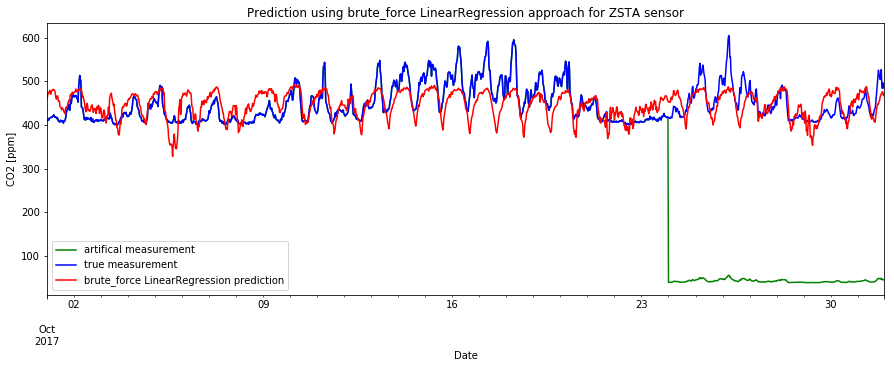

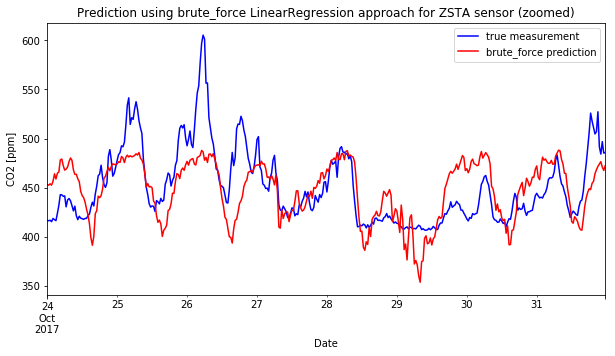

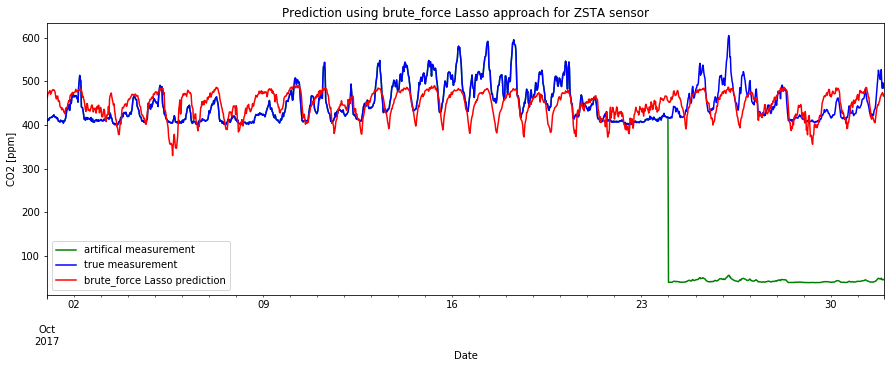

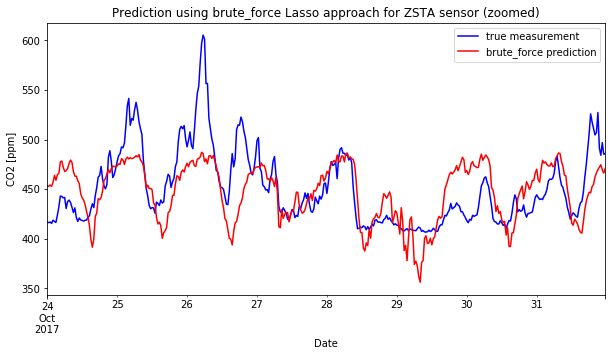

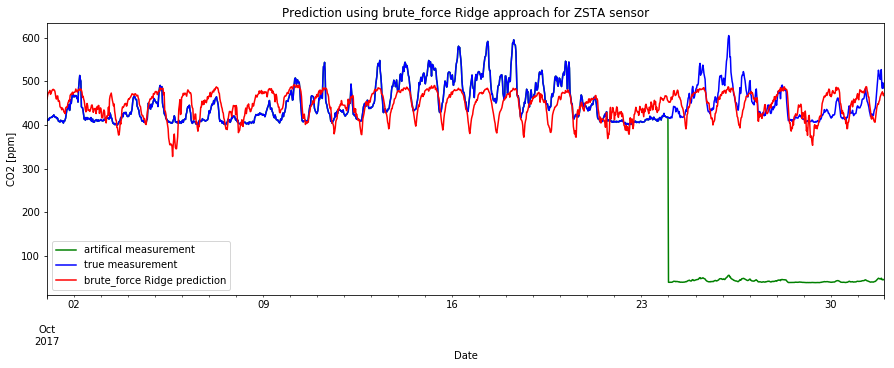

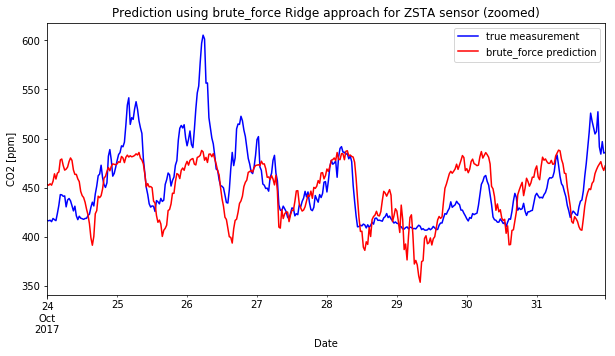

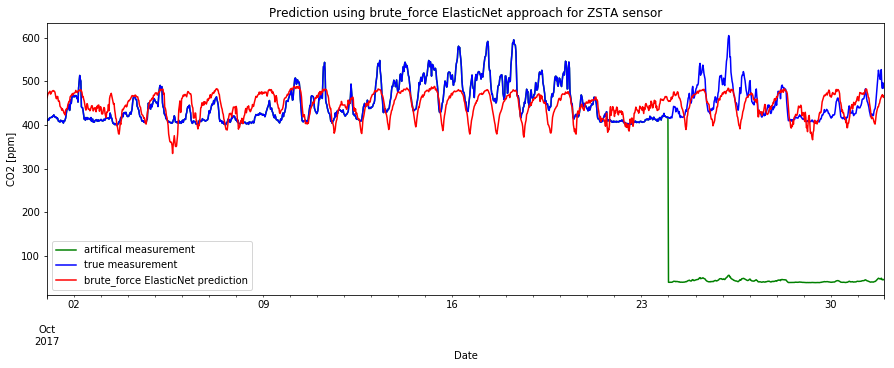

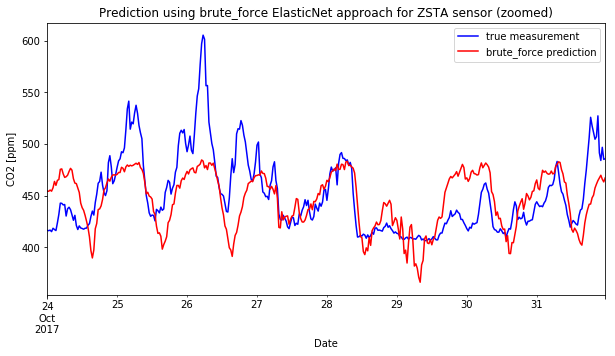

In [42]:
sensor = 'ZSTA'
approach = 'brute_force'
for reg in regs:
    plot_prediction(df_complete, sensor, approach, reg)
    plot_zoomed_prediction(df_complete, sensor, approach, reg)

In [59]:
regs = ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet']
reg = ['LinearRegression']
print_MSE(df_complete, faulty_sensors, ['naive'], regs)


AJGR sensor
-----------
*****
MSE for naive LinearRegression prediction: 44.44
MSE for naive Lasso prediction: 46.45
MSE for naive Ridge prediction: 44.44
MSE for naive ElasticNet prediction: 46.30

BSCR sensor
-----------
*****
MSE for naive LinearRegression prediction: 4995.48
MSE for naive Lasso prediction: 4977.71
MSE for naive Ridge prediction: 4995.42
MSE for naive ElasticNet prediction: 4956.99

ZSTA sensor
-----------
*****
MSE for naive LinearRegression prediction: 1501.71
MSE for naive Lasso prediction: 1468.92
MSE for naive Ridge prediction: 1501.59
MSE for naive ElasticNet prediction: 1429.41

ZUE sensor
-----------
*****
MSE for naive LinearRegression prediction: 1109.11
MSE for naive Lasso prediction: 1076.06
MSE for naive Ridge prediction: 1108.99
MSE for naive ElasticNet prediction: 1039.99


### Plots for presentation

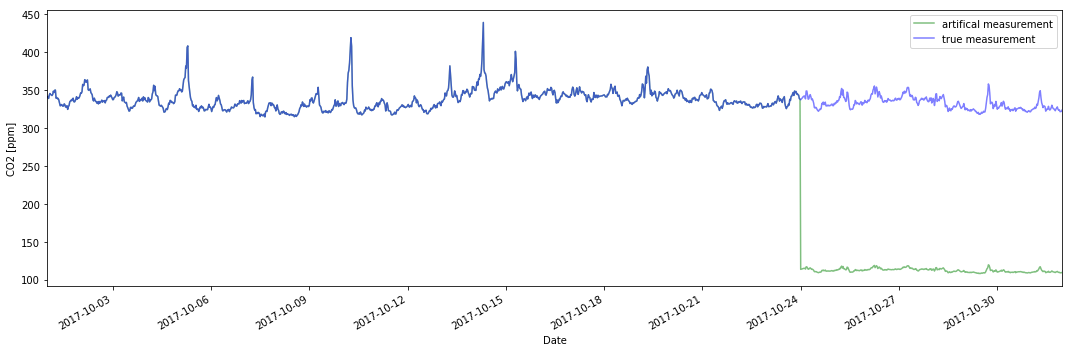

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
df_complete[df_complete['LocationName'] == 'AJGR'][['CO2', 'groundtruth']].plot(ax=ax, alpha=0.5, color=['g', 'b'])
plt.xlabel('Date')
plt.ylabel('CO2 [ppm]')
plt.legend(['artifical measurement', 'true measurement'])
plt.tight_layout()
plt.savefig('figures/ajgr_sensor_example.png', dpi=300)

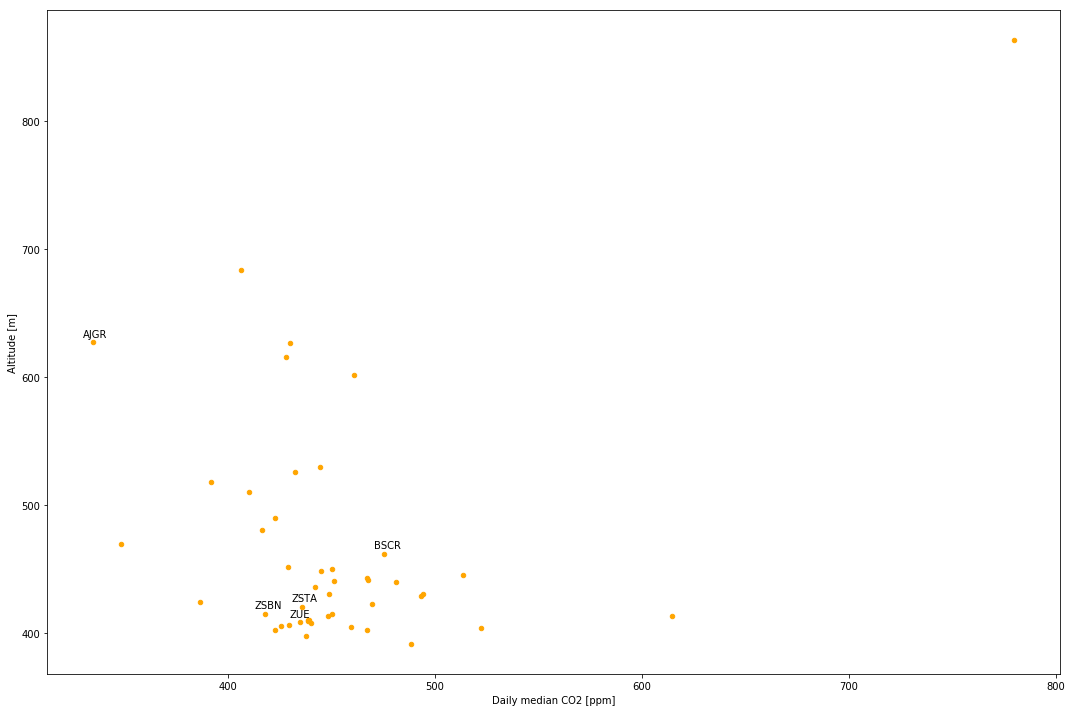

In [49]:
fig, ax = plt.subplots(figsize=(15,10))
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
ma.plot(x='median CO2', y='altitude', kind='scatter', color='orange', ax=ax)

for k, v in ma[['median CO2', 'altitude']].iterrows():
    if k in faulty_sensors or k == 'ZSBN':
        ax.annotate(k, v, xytext=(-10,5), textcoords='offset points', fontsize=10)

#plt.title('Sensor visualisation based on altitude and median CO2 measurement')
plt.xlabel('Daily median CO2 [ppm]')
plt.ylabel('Altitude [m]')
plt.tight_layout()
plt.savefig('figures/sensor_pos.png', dpi=300)

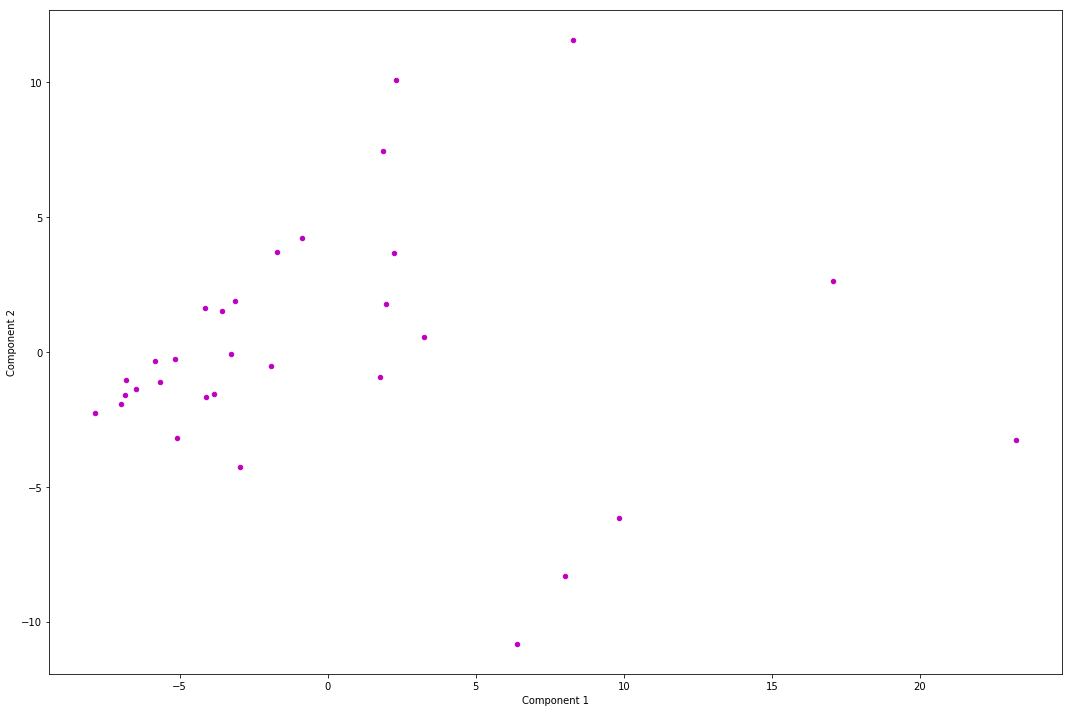

In [50]:
fig, ax = plt.subplots(figsize=(15,10))
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
pca_components.plot(x='component_1', y='component_2', kind='scatter', color='m', ax=ax)

#plt.title('Sensor visualisation based on altitude and median CO2 measurement')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.savefig('figures/wind_components.png', dpi=300)